In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
plt.style.use('seaborn-deep')

def linear(x, m, b):
    return m*x + b

Jetson TX2

In [3]:
FOLDER = "../../results/jetson_tx2/"
jetson_data = pd.read_csv(FOLDER + 'mobilenetv2.csv.gz', compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
jetson_data = jetson_data[jetson_data['protocol']=='grpc']
jetson_data = jetson_data[jetson_data['batchsize']==1]
jetson_data = jetson_data[jetson_data['instance_count']==1]

/opt/ec_solver/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
jetson_data = jetson_data.assign(request_count_diff=jetson_data.request_count.diff())
jetson_data = jetson_data.assign(queue_time_ms=jetson_data.queue_total_time_ns.diff()/(jetson_data.num_clients*10**6))
jetson_data = jetson_data.assign(compute_time_ms=jetson_data.compute_total_time_ns.diff()/(jetson_data.num_clients*10**6))
jetson_data = jetson_data[jetson_data.num_clients == jetson_data.request_count_diff]

In [5]:
jetson_tx2_x = np.array([1,2,3,4,5,10,15,20,40])
grouped = jetson_data.groupby(by=jetson_data.num_clients)
jetson_tx2_qt_ms = []
jetson_tx2_qt_ms_mean = []

for _,s in grouped:
    jetson_tx2_qt_ms.append(s.queue_time_ms)
    jetson_tx2_qt_ms_mean.append(s.queue_time_ms.mean())

jetson_tx2_y = np.array(jetson_tx2_qt_ms_mean)

jetson_tx2_popt, jetson_tx2_pcov_linear = scipy.optimize.curve_fit(linear, jetson_tx2_x, jetson_tx2_y, p0=[((75-25)/(44-2)), 0])
jetson_tx2_perr_linear = np.sqrt(np.diag(jetson_tx2_pcov_linear))
print("slope = {} (+/-) {}".format(jetson_tx2_popt[0], jetson_tx2_perr_linear[0]))
print("y-intercept = {} (+/-) {}".format(jetson_tx2_popt[1], jetson_tx2_perr_linear[1]))

slope = 23.314395066539365 (+/-) 0.2339726698384261
y-intercept = -41.494938575177194 (+/-) 3.8048046638985835


In [6]:
FOLDER = "../../results/gtx1060/"
gtx1060_data = pd.read_csv(FOLDER + 'mobilenetv2.csv.gz', compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
gtx1060_data = gtx1060_data[gtx1060_data['protocol']=='grpc']
gtx1060_data = gtx1060_data[gtx1060_data['batchsize']==1]
gtx1060_data = gtx1060_data[gtx1060_data['instance_count']==1]

gtx1060_data = gtx1060_data.assign(request_count_diff=gtx1060_data.request_count.diff()) \
                .assign(queue_time_ms=gtx1060_data.queue_total_time_ns.diff()/(gtx1060_data.num_clients*10**6)) \
                .assign(compute_time_ms=gtx1060_data.compute_total_time_ns.diff()/(gtx1060_data.num_clients*10**6))

gtx1060_data = gtx1060_data[gtx1060_data.num_clients == gtx1060_data.request_count_diff]

gtx1060_x = np.array([1,2,3,4,5,10,15,20,40])
grouped = gtx1060_data.groupby(by=gtx1060_data.num_clients)
gtx1060_data_qt_ms = []
gtx1060_data_qt_ms_mean = []

for _,s in grouped:
    gtx1060_data_qt_ms.append(s.queue_time_ms)
    gtx1060_data_qt_ms_mean.append(s.queue_time_ms.mean())

gtx1060_y = np.array(gtx1060_data_qt_ms_mean)
gtx1060_data_popt, _ = scipy.optimize.curve_fit(linear, gtx1060_x, gtx1060_y, p0=[((75-25)/(44-2)), 0])

mean = np.mean(gtx1060_data.compute_time_ms)                  
variance = np.std(gtx1060_data.compute_time_ms)

gtx1060_gs = np.random.normal(mean, variance, 1000)

2x RTX 2080Ti

In [7]:
FOLDER = "../../results/gpu_server_rtx2080/"
rtx2080_data = pd.read_csv(FOLDER + 'mobilenetv2_b1_p99_c256.csv', header=0, sep=',', quotechar='"', error_bad_lines=False)
rtx2080_data_queue_time = rtx2080_data['Server Queue'] / 10**3
rtx2080_data_compute_time = rtx2080_data['Server Compute'] / 10**3
rtx2080_data_clients = rtx2080_data['Concurrency']

In [8]:
rtx2080_x = rtx2080_data_clients.unique()
rtx2080_y = np.array(rtx2080_data_queue_time)

rtx2080_data_popt, rtx2080_data_pcov_linear = scipy.optimize.curve_fit(linear, rtx2080_x, rtx2080_y, p0=[((75-25)/(44-2)), 0])
rtx2080_data_perr_linear = np.sqrt(np.diag(rtx2080_data_pcov_linear))
print("slope = {} (+/-) {}".format(rtx2080_data_popt[0], rtx2080_data_perr_linear[0]))
print("y-intercept = {} (+/-) {}".format(rtx2080_data_popt[1], rtx2080_data_perr_linear[1]))

slope = 0.6556470588930683 (+/-) 0.001966896679087912
y-intercept = -11.880029883197805 (+/-) 0.2915621622448286


Plots

TypeError: subplots_adjust() got an unexpected keyword argument 'vspace'

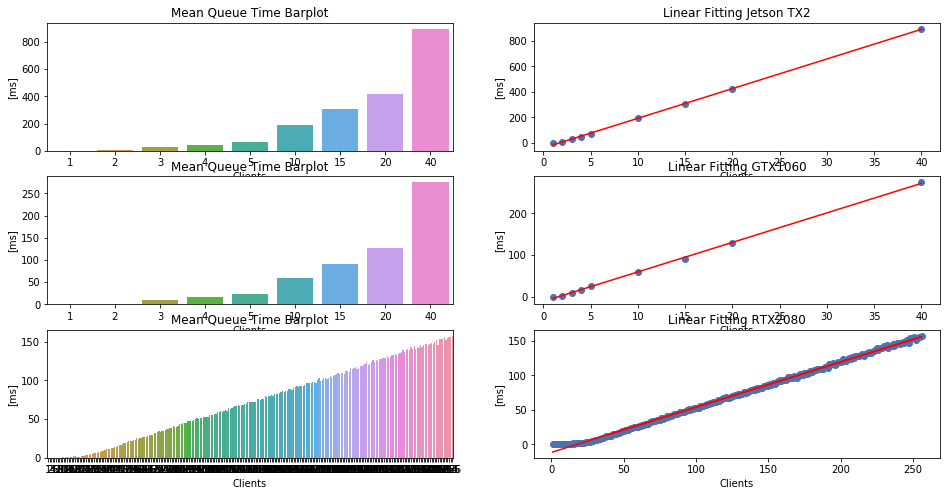

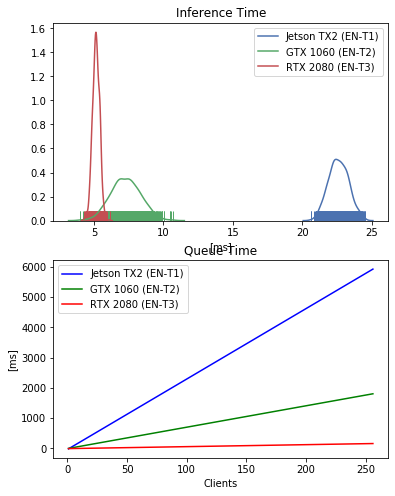

In [28]:
fig, ax = plt.subplots(3, 2, figsize=(16, 8))

## Jetson TX2
sns.barplot(x=jetson_tx2_x, y=jetson_tx2_qt_ms_mean, ax=ax[0][0])
ax[0][0].set_title("Mean Queue Time Barplot")
ax[0][0].set_ylabel("[ms]")
ax[0][0].set_xlabel("Clients")

ax[0][1].scatter(jetson_tx2_x, jetson_tx2_y)
ax[0][1].plot(jetson_tx2_x, linear(jetson_tx2_x, *jetson_tx2_popt),'r')
ax[0][1].set_title("Linear Fitting Jetson TX2")
ax[0][1].set_ylabel("[ms]")
ax[0][1].set_xlabel("Clients")

## GTX 1060
sns.barplot(x=gtx1060_x, y=gtx1060_y, ax=ax[1][0])
ax[1][0].set_title("Mean Queue Time Barplot")
ax[1][0].set_ylabel("[ms]")
ax[1][0].set_xlabel("Clients")

ax[1][1].scatter(gtx1060_x, gtx1060_y)
ax[1][1].plot(gtx1060_x, linear(gtx1060_x, *gtx1060_data_popt),'r')
ax[1][1].set_title("Linear Fitting GTX1060")
ax[1][1].set_ylabel("[ms]")
ax[1][1].set_xlabel("Clients")

## RTX 2080
sns.barplot(x=rtx2080_x, y=rtx2080_y, ax=ax[2][0])
ax[2][0].set_title("Mean Queue Time Barplot")
ax[2][0].set_ylabel("[ms]")
ax[2][0].set_xlabel("Clients")

ax[2][1].scatter(rtx2080_x, rtx2080_y)
ax[2][1].plot(rtx2080_x, linear(rtx2080_x, *rtx2080_data_popt),'r')
ax[2][1].set_title("Linear Fitting RTX2080")
ax[2][1].set_ylabel("[ms]")
ax[2][1].set_xlabel("Clients")

# Compute Time Gaussians
drange = 1000
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
x = np.linspace(1,256,256)

mean = np.mean(jetson_data.compute_time_ms)                  
variance = np.std(jetson_data.compute_time_ms)

gs = np.random.normal(mean, variance, drange)
sns.distplot(gs, hist=False, rug=True, ax=ax[0], label="Jetson TX2 (EN-T1)")

sns.distplot(gtx1060_gs, hist=False, rug=True, ax=ax[0], label="GTX 1060 (EN-T2)")

mean = np.mean(rtx2080_data_compute_time)                  
variance = np.std(rtx2080_data_compute_time)

gs = np.random.normal(mean, variance, drange)
sns.distplot(gs, hist=False, rug=True, ax=ax[0], label="RTX 2080 (EN-T3)")
ax[0].set_title("Inference Time")
ax[0].set_xlabel("[ms]")

ax[1].plot(x, linear(x, *jetson_tx2_popt),'b', label="Jetson TX2 (EN-T1)")
ax[1].plot(x, linear(x, *gtx1060_data_popt),'g', label="GTX 1060 (EN-T2)" )
ax[1].plot(x, linear(x, *rtx2080_data_popt),'r', label="RTX 2080 (EN-T3)")
ax[1].legend(loc='upper left')
ax[1].set_title("Queue Time")
ax[1].set_ylabel("[ms]")
ax[1].set_xlabel("Clients")

fig.subplots_adjust(vspace=0.4)
fig.tight_layout()
fig.savefig('../../plots/inference_queue_time.pdf', bbox_inches="tight")

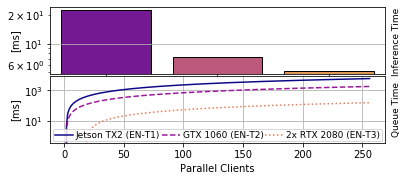

In [63]:
# Compute Time Gaussians
drange = 1000
fig, ax = plt.subplots(2, 1, figsize=(6, 2.5))
x = np.linspace(1,256,256)
linestyles = ['-', '--', ':']

cls = plt.cm.get_cmap("plasma", 4).colors
# add axes with (left, bottom, width, height) (range 0 to 1)

mean = np.mean(jetson_data.compute_time_ms)                  
variance = np.std(jetson_data.compute_time_ms)

gs1 = np.random.normal(mean, variance, drange)
#sns.distplot(gs, hist=False, rug=True, ax=axes1, label="Jetson TX2 (EN-T1)")
#sns.distplot(gtx1060_gs, hist=False, rug=True, ax=axes1, label="GTX 1060 (EN-T2)")

mean = np.mean(rtx2080_data_compute_time)                  
variance = np.std(rtx2080_data_compute_time)

gs2 = np.random.normal(mean, variance, drange)
#sns.distplot(gs, hist=False, rug=True, ax=axes1, label="2x RTX 2080 (EN-T3)")

sns.barplot(
    x=["Jetson TX2 (EN-T1)", "GTX 1060 (EN-T2)", "2x RTX 2080 (EN-T3)"],
    y=[np.median(gs1), np.median(gtx1060_gs), np.median(gs2)],
    palette="plasma",
    edgecolor="black",
    ax=ax[0]
)

ax[0].set_ylabel("[ms]", labelpad=-13)
ax[0].grid(axis='y')
ax[0].set_yscale("log")
# ax[0].yaxis.set_ticks(np.arange(0, 30,5))

plt.setp(ax[0].get_xticklabels(), visible=False)

ax[1].plot(x, linear(x, *jetson_tx2_popt),'b', label="Jetson TX2 (EN-T1)", color=cls[0], linestyle=linestyles[0])
ax[1].plot(x, linear(x, *gtx1060_data_popt),'g', label="GTX 1060 (EN-T2)", color=cls[1], linestyle=linestyles[1])
ax[1].plot(x, linear(x, *rtx2080_data_popt),'r', label="2x RTX 2080 (EN-T3)", color=cls[2], linestyle=linestyles[2])

ax[1].set_ylabel("[ms]")
ax[1].set_xlabel("Parallel Clients")
ax[1].set_yscale("log")
ax[1].legend(loc='lower right')
ax[1].grid()

ax[0].text(1.02, 1.5, "Inference Time", {'fontsize': 9},
         horizontalalignment='left',
         verticalalignment='center',
         rotation=90,
         clip_on=False,
         transform=plt.gca().transAxes)
   
ax[1].text(1.02, 0.5, "Queue Time", {'fontsize': 9},
     horizontalalignment='left',
     verticalalignment='center',
     rotation=90,
     clip_on=False,
     transform=plt.gca().transAxes)

ax[1].legend(ncol=3,borderpad=0.2, loc=8,
                labelspacing=0.1, handletextpad=0.3,
                borderaxespad=0.15, columnspacing=0.2, fontsize=9)


plt.subplots_adjust(hspace=.02)

fig.savefig('../../plots/inference_queue_time_box.pdf', bbox_inches="tight")

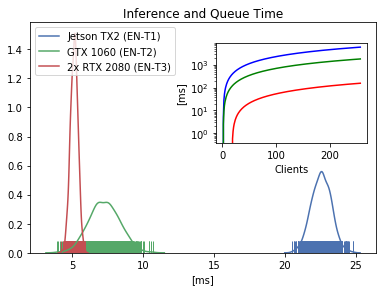

In [38]:
# Compute Time Gaussians
drange = 1000
fig = plt.figure()
x = np.linspace(1,256,256)

# add axes with (left, bottom, width, height) (range 0 to 1)
axes1 = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
axes2 = fig.add_axes([0.53, 0.48, 0.35, 0.35]) # inset axes

mean = np.mean(jetson_data.compute_time_ms)                  
variance = np.std(jetson_data.compute_time_ms)

gs = np.random.normal(mean, variance, drange)
sns.distplot(gs, hist=False, rug=True, ax=axes1, label="Jetson TX2 (EN-T1)")
sns.distplot(gtx1060_gs, hist=False, rug=True, ax=axes1, label="GTX 1060 (EN-T2)")

mean = np.mean(rtx2080_data_compute_time)                  
variance = np.std(rtx2080_data_compute_time)

gs = np.random.normal(mean, variance, drange)
sns.distplot(gs, hist=False, rug=True, ax=axes1, label="2x RTX 2080 (EN-T3)")
axes1.set_title("Inference and Queue Time")
axes1.set_xlabel("[ms]")
axes1.legend(loc='upper left')

axes2.plot(x, linear(x, *jetson_tx2_popt),'b', label="Jetson TX2 (EN-T1)")
axes2.plot(x, linear(x, *gtx1060_data_popt),'g', label="GTX 1060 (EN-T2)" )
axes2.plot(x, linear(x, *rtx2080_data_popt),'r', label="RTX 2080 (EN-T3)")

axes2.set_ylabel("[ms]")
axes2.set_xlabel("Clients")
axes2.set_yscale("log")

fig.subplots_adjust(hspace=0.3)
fig.savefig('../../plots/inset_inference_queue_time.pdf')